In [1]:
import fitsio as ft
import numpy  as np
import healpy as hp
import os
import sys

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
class mock(object):
    def __init__(self, featsfile, paramsfile, func='lin', sf=1207432.7901):
        # read inputs
        feats       = ft.read(featsfile)
        params      = np.load(paramsfile, allow_pickle=True).item()
        # attrs
        self.hpix   = feats['hpind']
        self.feats  = feats['features']
        self.axfit     = params['ax']
        self.xstats = params['xstats']
        #print('Will scale the covariance by %.4f'%sf)
        bfp_raw     = params['params'][func]
        self.bfp    = (bfp_raw[0], sf*bfp_raw[1])

        #
        # prepare
        self.n   = self.feats.shape[0]
        x        = (self.feats - self.xstats[0])/self.xstats[1] # select axis
        x_scaled = x[:, self.axfit]
        if func == 'lin':
            x_vector = np.column_stack([np.ones(self.n), x_scaled])
        elif func == 'quad':
            x_vector = np.column_stack([np.ones(self.n), x_scaled, x_scaled*x_scaled])
        else:
            exit(f"func:{func} is not defined")
        #
        # 
        self.x_vector = x_vector

    def simulate(self, kind='truth', seed=12345):
        if kind not in ['fixed', 'random', 'truth']:
            exit(f"kind : {kind} is not defined")
        np.random.seed(seed) # set the seed

        if kind == 'truth':
            thetas = self.bfp[0]
        elif kind == 'fixed':
            thetas = np.random.multivariate_normal(*self.bfp)
        elif kind == 'random':
            thetas = np.random.multivariate_normal(*self.bfp, size=self.n)
        else:
            exit(f"kind : {kind} is not defined")

        tx       = (thetas * self.x_vector)
        self.txs = np.sum(tx, axis=1)

    def project(self, hpin, tag):
        hpmin = hp.read_map(hpin, verbose=False)
        fpath = '/'.join((hpin.split('/')[:-1] + [tag]))
        mname = '_'.join((tag, 'mask',hpin.split('/')[-1]))
        fname = '_'.join((tag, hpin.split('/')[-1]))
        if not os.path.exists(fpath):
            os.makedirs(fpath)
         
        self.ngalcont = self.txs * hpmin[self.hpix]  
        fou = '/'.join((fpath, fname))
        mou = '/'.join((fpath, mname))
        
        ngal_neg   = self.ngalcont < 0.0
        hpix_neg   = self.hpix[ngal_neg]
        hpix_noneg = self.hpix[~ngal_neg]
        ngal_noneg = self.ngalcont[~ngal_neg]
        #
        #
        ngalm      = np.zeros_like(hpmin)
        ngalm[hpix_noneg] = np.random.poisson(ngal_noneg)
        #
        #
        self.negm = np.zeros_like(hpmin)
        self.negm[self.hpix]  = self.ngalcont
        #hp.write_map(mou, negm,  fits_IDL=False, overwrite=True, dtype=np.float64)
        #hp.write_map(fou, ngalm, fits_IDL=False, overwrite=True, dtype=np.float64)
        #print('%s is written'%fou) 
        

In [4]:
np.random.seed(123456) # set the global seed        
seeds = np.random.randint(0, 4294967295, size=1000)        
seeds[0]

545331265

In [5]:
regp = '/Volumes/TimeMachine/data/DR7/results/regression/mult_ab/regression_log.npy'
feats = '/Volumes/TimeMachine/data/mocks/mocks.DR7.table.fits'
mock_i = '/Volumes/TimeMachine/data/mocks/testshotnoise/001.hp.256.fits'

mymock  = mock(feats, 
               regp,
               func='lin', sf=23765.2929*0.05) # 0.1XtotalfracXvarngal = 2376.52929
mymock.simulate(kind='random', seed=545331265)
mymock.project(mock_i, 'cp2ptest')
ngal_test = mymock.negm.copy()

mymock.simulate(kind='truth', seed=545331265)
mymock.project(mock_i, 'cp2ptest')
ngal_test_truth = mymock.negm.copy()

In [6]:
ngal_null = hp.read_map('/Volumes/TimeMachine/data/mocks/testshotnoise/001.hp.256.fits') 
#ngal_test = hp.read_map('/Volumes/TimeMachine/data/mocks/testshotnoise/cp2ptest/cp2ptest_001.hp.256.fits')
ngal_org = hp.read_map('/Volumes/TimeMachine/data/mocks/testshotnoise/cp2p_001.hp.256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [7]:
frac = hp.read_map('/Volumes/TimeMachine/data/mocks/fracgood.hp256.fits')
mask = hp.read_map('/Volumes/TimeMachine/data/mocks/mask.cut.w.hp.256.fits') > 0

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [8]:
wlin = hp.read_map('/Volumes/TimeMachine/data/mocks/3dbox/001/results/regression/mult_all/lin-weights.hp256.fits')
wlinc = hp.read_map('/Volumes/TimeMachine/data/mocks/3dbox/001/cp2p/results/regression/mult_all/lin-weights.hp256.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [9]:
ngal_null_w = ngal_null/wlin
ngal_org_w = ngal_org/wlinc

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


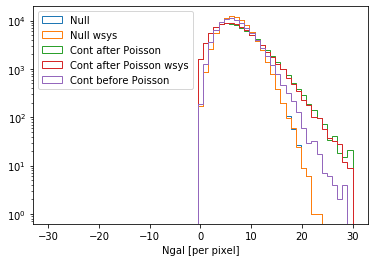

In [10]:
kw = {'histtype':'step', 'bins':np.linspace(-30, 30, 60)}
plt.hist(ngal_null[mask], **kw, label='Null')
plt.hist(ngal_null_w[mask], **kw, label='Null wsys')
plt.hist(ngal_org[mask], **kw, label='Cont after Poisson')
plt.hist(ngal_org_w[mask], **kw, label='Cont after Poisson wsys')
plt.hist(ngal_test[mask], **kw, label='Cont before Poisson')
plt.yscale('log')
plt.xlabel('Ngal [per pixel]')
plt.legend(loc='upper left')

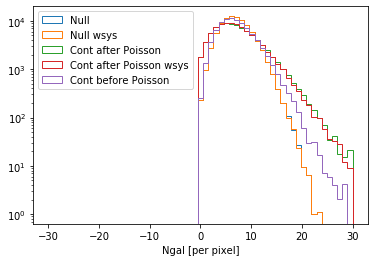

In [12]:
kw = {'histtype':'step', 'bins':np.linspace(-30, 30, 60), 'weights':1./frac[mask]}
plt.hist(ngal_null[mask], **kw, label='Null')
plt.hist(ngal_null_w[mask], **kw, label='Null wsys')
plt.hist(ngal_org[mask], **kw, label='Cont after Poisson')
plt.hist(ngal_org_w[mask], **kw, label='Cont after Poisson wsys')
plt.hist(ngal_test[mask], **kw, label='Cont before Poisson')
plt.yscale('log')
plt.xlabel('Ngal [per pixel]')
plt.legend(loc='upper left')

In [13]:
totalarea = hp.nside2pixarea(256, degrees=True)*3.0462e-4*mask.sum()
area1pix = totalarea / mask.sum()
print(f'total area : {totalarea}, area 1 pix : {area1pix}')

total area : 1.3880566436844042, area 1 pix : 1.5979101887764102e-05


In [14]:
for name, ngali in zip(['Null', 'Cont.', 'Cont. before Poisson'],
                       [ngal_null, ngal_org, ngal_test]):
    
    print(f'{name:20s}, {np.average(ngali[mask], weights=1./frac[mask])} {np.std(ngali[mask])}')

Null                , 6.860573378588779 2.8370046222146277
Cont.               , 7.031814214075481 4.248943830655374
Cont. before Poisson, 7.0488729506701295 3.31634843934611


In [15]:
def ssclustering(std, Nbar):
    area1pix = 1.5979101887764102e-05
    
    nbar = Nbar / area1pix    # per steradians
    sq_nbar = nbar*nbar       # per sq. steradians
    sq_std = std*std / area1pix # per steradians
    
    small_scale_clustering = sq_std/sq_nbar - (1./nbar)
    
    print(sq_std/sq_nbar, 1./nbar, small_scale_clustering)
    #return small_scale_clustering

In [16]:
for name, ngali in zip(['Null', 'Cont.', 'Cont. before Poisson'],
                       [ngal_null, ngal_org, ngal_test]):
    
    std = np.std(ngali[mask]/frac[mask])
    Nbar = np.mean(ngali[mask]/frac[mask])
    
    print(f'{name:20s}', end=' ')
    ssclustering(std, Nbar)

Null                 2.853234291573167e-06 2.2982424514597833e-06 5.549918401133836e-07
Cont.                5.969930037105104e-06 2.2422749663190055e-06 3.7276550707860984e-06
Cont. before Poisson 3.6556365479861135e-06 2.2368485132830526e-06 1.418788034703061e-06


In [37]:
3.33e-7/0.10912503642658404

3.0515453731283023e-06

In [31]:
5.969930037105104e-06 - 2.853234291573167e-06

3.116695745531937e-06

In [38]:
area1pix*(1/6.860573378588779+1/7.031814214075481)/ 3.0515453731283023e-06 

1.5079315364101826

In [36]:
5.41493819699172e-06 - 2.853234291573167e-06

2.5617039054185533e-06

In [30]:
shotnoise_cont = 5.969930037105104e-06 - 5.549918401133836e-07 # sq_sig - small. scale. clustering
shotnoise_cont_woPoisson = 3.6556365479861135e-06 - 5.549918401133836e-07 # sq_sig - small. scale. clustering
print(shotnoise_cont, shotnoise_cont_woPoisson)

5.41493819699172e-06 3.10064470787273e-06


In [17]:
def anafast(map1, weight1, mask1):
    hmap1 = hp.ma(map1*weight1)
    hmap1.mask = np.logical_not(mask1)
    hmap1 = hmap1.filled()
    
    return hp.anafast(hmap1, lmax=512)/np.mean(mask1)

In [18]:
from utils import makedelta

camb is not installed!


In [19]:
d_null = makedelta(ngal_null, frac, mask)
d_org = makedelta(ngal_org, frac, mask)
d_test = makedelta(ngal_test, frac, mask)
d_test_truth = makedelta(ngal_test_truth, frac, mask)

In [20]:
cl_null = anafast(d_null, frac, mask)
cl_cont = anafast(d_org, frac, mask)
cl_test = anafast(d_test, frac, mask)
cl_truth = anafast(d_test_truth, frac, mask)

In [21]:
cl_null_t = np.load('/Volumes/TimeMachine/data/mocks/3dbox/001/results/clustering/cl_uni.npy', allow_pickle=True).item()
cl_cont_t = np.load('/Volumes/TimeMachine/data/mocks/3dbox/001/cp2p/results/clustering/cl_uni.npy', allow_pickle=True).item()

(1e-06, 0.001)

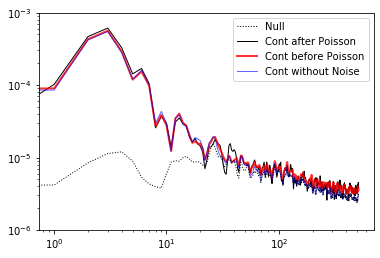

In [23]:
plt.loglog(cl_null, c='k', ls=':', lw=1, zorder=10)           
plt.loglog(cl_cont-2.266925134457511e-06, c='k', lw=1)
plt.loglog(cl_test, c='r', lw=2, alpha=0.8)
plt.loglog(cl_truth, c='b', lw=1, alpha=0.6)
plt.legend(['Null', 'Cont after Poisson', 'Cont before Poisson', 'Cont without Noise'])
plt.ylim(1.0e-6, 1.0e-3)

In [5]:
frac = hp.read_map('/Volumes/TimeMachine/data/mocks/fracgood.hp256.fits', verbose=False)
mask = hp.read_map('/Volumes/TimeMachine/data/mocks/mask.cut.w.hp.256.fits', verbose=False) > 0

In [6]:
def shotnoise(galmap, frac, mask):
    std = np.std(galmap[mask]/frac[mask])
    Nbar = np.mean(galmap[mask]/frac[mask])
    
    area1pix = 1.5979101887764102e-05
    
    nbar = Nbar / area1pix    # per steradians
    sq_nbar = nbar*nbar       # per sq. steradians
    sq_std = std*std / area1pix # per steradians
    
    return sq_std/sq_nbar

In [7]:
null = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/{i:03d}.hp.256.fits'
cont = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/cp2p/cp2p_{i:03}.hp.256.fits'

In [8]:
df = {}

In [9]:
df['null'] = np.zeros(100)
df['cont'] = np.zeros(100)

for i in range(0, 100):
    gnull = hp.read_map(null(i+1), verbose=False)
    gcont = hp.read_map(cont(i+1), verbose=False)
    
    df['null'][i] = shotnoise(gnull, frac, mask)
    df['cont'][i] = shotnoise(gcont, frac, mask)
    
    print('.', end='')

....................................................................................................

In [10]:
df['cont_mult_all_lin'] = np.zeros(100)

contw = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/cp2p/results/regression/mult_all/lin-weights.hp256.fits'

for i in range(0, 100):
    
    gcont = hp.read_map(cont(i+1), verbose=False)
    wcont = hp.read_map(contw(i+1), verbose=False)
    
    df['cont_mult_all_lin'][i] = shotnoise(gcont/wcont, frac, mask)
    
    print('.', end='')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


....................................................................................................

In [11]:
df['cont_mult_all_quad'] = np.zeros(100)

contw = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/cp2p/results/regression/mult_all/quad-weights.hp256.fits'

for i in range(0, 100):
    
    gcont = hp.read_map(cont(i+1), verbose=False)
    wcont = hp.read_map(contw(i+1), verbose=False)
    
    df['cont_mult_all_quad'][i] = shotnoise(gcont/wcont, frac, mask)
    
    print('.', end='')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


....................................................................................................

In [12]:
df['cont_mult_f_lin'] = np.zeros(100)

contw = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/cp2p/results/regression/mult_f/lin-weights.hp256.fits'

for i in range(0, 100):
    
    gcont = hp.read_map(cont(i+1), verbose=False)
    wcont = hp.read_map(contw(i+1), verbose=False)
    
    df['cont_mult_f_lin'][i] = shotnoise(gcont/wcont, frac, mask)
    
    print('.', end='')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


....................................................................................................

In [13]:
df['cont_mult_f_quad'] = np.zeros(100)

contw = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/cp2p/results/regression/mult_f/quad-weights.hp256.fits'

for i in range(0, 100):
    
    gcont = hp.read_map(cont(i+1), verbose=False)
    wcont = hp.read_map(contw(i+1), verbose=False)
    
    df['cont_mult_f_quad'][i] = shotnoise(gcont/wcont, frac, mask)
    
    print('.', end='')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


....................................................................................................

In [14]:
df['cont_mult_t_lin'] = np.zeros(100)

contw = lambda i:f'/Volumes/TimeMachine/data/DR7/results/regression/mult_ab/lin-weights.hp256.fits'

for i in range(0, 100):
    
    gcont = hp.read_map(cont(i+1), verbose=False)
    wcont = hp.read_map(contw(i+1), verbose=False)
    
    df['cont_mult_t_lin'][i] = shotnoise(gcont/wcont, frac, mask)
    
    print('.', end='')


/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


....................................................................................................

In [15]:
df['cont_nn_f_nn'] = np.zeros(100)

contw = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/cp2p/results/regression/nn_f/nn-weights.hp256.fits'

for i in range(0, 100):
    
    gcont = hp.read_map(cont(i+1), verbose=False)
    wcont = hp.read_map(contw(i+1), verbose=False)
    
    df['cont_nn_f_nn'][i] = shotnoise(gcont/wcont, frac, mask)
    
    print('.', end='')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


....................................................................................................

In [16]:
df['cont_nn_p_nn'] = np.zeros(100)

contw = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/cp2p/results/regression/nn_p/nn-weights.hp256.fits'

for i in range(0, 100):
    
    gcont = hp.read_map(cont(i+1), verbose=False)
    wcont = hp.read_map(contw(i+1), verbose=False)
    
    df['cont_nn_p_nn'][i] = shotnoise(gcont/wcont, frac, mask)
    
    print('.', end='')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


....................................................................................................

In [17]:
df['cont_nn_ab_nn'] = np.zeros(100)

contw = lambda i:f'/Volumes/TimeMachine/data/mocks/3dbox/{i:03d}/cp2p/results/regression/nn_ab/nn-weights.hp256.fits'

for i in range(0, 100):
    
    gcont = hp.read_map(cont(i+1), verbose=False)
    wcont = hp.read_map(contw(i+1), verbose=False)
    
    df['cont_nn_ab_nn'][i] = shotnoise(gcont/wcont, frac, mask)
    
    print('.', end='')

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


....................................................................................................

In [18]:
np.save('/Volumes/TimeMachine/data/mocks/shotnoises.npy', df)

In [19]:
df.keys()

dict_keys(['null', 'cont', 'cont_mult_all_lin', 'cont_mult_all_quad', 'cont_mult_f_lin', 'cont_mult_f_quad', 'cont_mult_t_lin', 'cont_nn_f_nn', 'cont_nn_p_nn', 'cont_nn_ab_nn'])

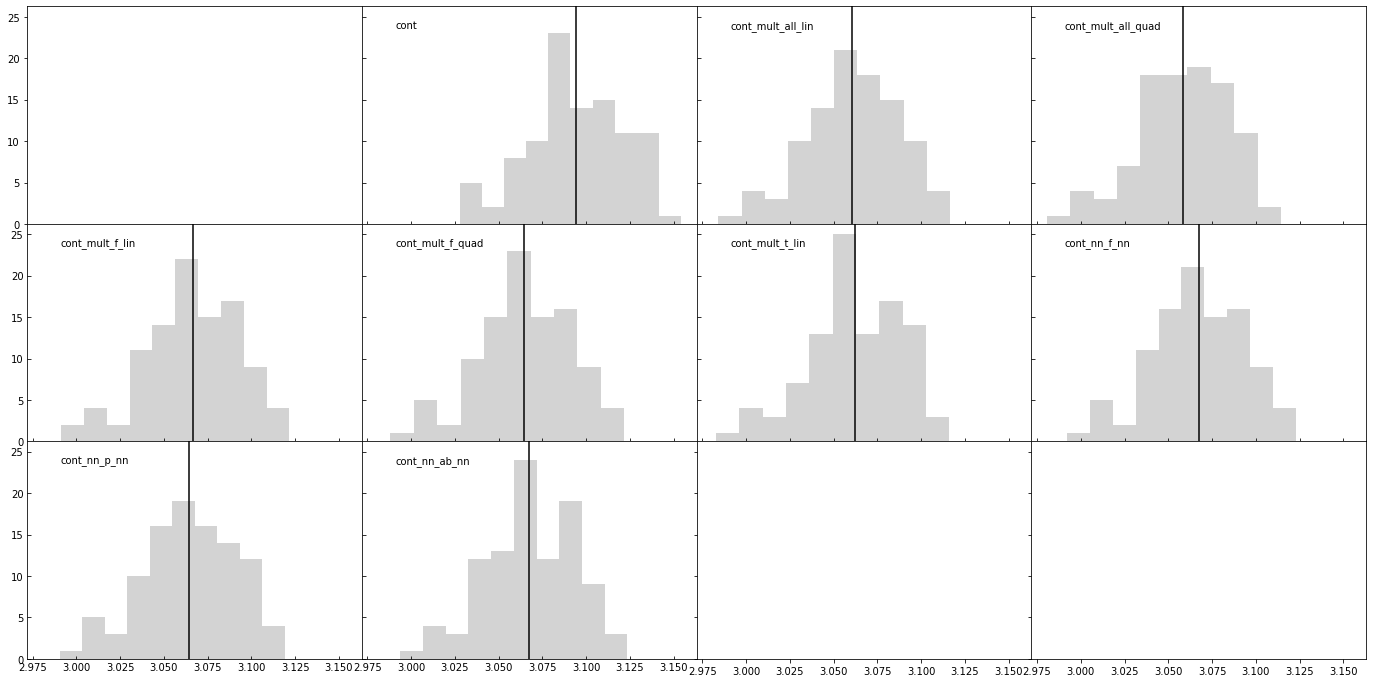

In [21]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(24, 12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

ax = ax.flatten()

for i,k in enumerate(df):
    if k == 'null':
        continue
    diff = 1.0e6*(df[k] - df['null'])
    ax[i].hist(diff, color='lightgrey')
    ax[i].axvline(np.mean(diff), color='k')
    
    ax[i].tick_params(direction='in', axis='both', which='both')
    ax[i].text(0.1, 0.9, k, transform=ax[i].transAxes)

In [22]:
mean_shotnoise = {}
for i,k in enumerate(df):
    
    if k == 'null':
        continue
        
    diff = (df[k] - df['null'])
    mean_shotnoise[k] = np.mean(diff)

In [23]:
mean_shotnoise

{'cont': 3.0941220401223286e-06,
 'cont_mult_all_lin': 3.0604730249556807e-06,
 'cont_mult_all_quad': 3.058199715218514e-06,
 'cont_mult_f_lin': 3.0665360485070298e-06,
 'cont_mult_f_quad': 3.064223200691407e-06,
 'cont_mult_t_lin': 3.0624094579073294e-06,
 'cont_nn_f_nn': 3.067444430857355e-06,
 'cont_nn_p_nn': 3.064252572210964e-06,
 'cont_nn_ab_nn': 3.0675114836640545e-06}

In [24]:
np.save('/Volumes/TimeMachine/data/mocks/mean_diffshotnoises.npy', mean_shotnoise)